# Descripción del proyecto

La compañía Sweet Lift Taxi ha recopilado datos históricos sobre pedidos de taxis en los aeropuertos. Para atraer a más conductores durante las horas pico, se construye un modelo para predecir la cantidad de pedidos de taxis para la próxima hora.

## Inicialización

In [1]:
# manejo de datos
#---------------------------
import numpy as np
import pandas as pd
import datetime
import math

# visualización
#---------------------------
import matplotlib.pyplot as plt
import seaborn as sns

# análisis exploratorio
from statsmodels.tsa.seasonal import seasonal_decompose
from scipy.fft import fft, rfft
from scipy.fft import fftfreq, rfftfreq

# pre-procesamiento
#---------------------------
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# modelos
#---------------------------
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
import lightgbm as lgb


# evaluación
#---------------------------
from sklearn.metrics import  mean_squared_error, r2_score
import time

## Inspección inicial de datos

Iniciamos importando los datos, mostrando la información general y el encabezado.

In [2]:
data = pd.read_csv('/datasets/taxi.csv')

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26496 entries, 0 to 26495
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   datetime    26496 non-null  object
 1   num_orders  26496 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 414.1+ KB


In [4]:
data.head()

,datetime,num_orders
0,2018-03-01 00:00:00,9
1,2018-03-01 00:10:00,14
2,2018-03-01 00:20:00,28
3,2018-03-01 00:30:00,20
4,2018-03-01 00:40:00,32


El data frame tiene 26496 entradas con dos columnas correspondientes a fecha y hora de la orden y número de órdenes realizadas. 

Se cambia el formato de la primera columna a datetime, se ordena y se fija como índice del dataframe.

In [5]:
data['datetime'] = pd.to_datetime(data['datetime'] , format='%Y-%m-%d %H:%M:%S')

In [6]:
data = data.set_index('datetime', drop=True).sort_index()

Se realiza un remuestreo para obtener el número de órdenes por hora

In [7]:
data = data.resample('1h').sum()

Para evitar usar datos del conjunto de prueba para el análisis, encontramos el índice a partir del cuál los datos pertenecen al último 10%.

In [8]:
round(data.shape[0]*0.9)

3974

La fecha correspondiente para este índice es:

In [9]:
data.iloc[round(data.shape[0]*0.9)].name

Timestamp('2018-08-13 14:00:00', freq='H')

Por lo cual las subsecuentes gráficas de análisis exploratorio contemplarán hasta esta fecha.

A continuación se muestra una gráfica de los datos:

<AxesSubplot:xlabel='datetime'>

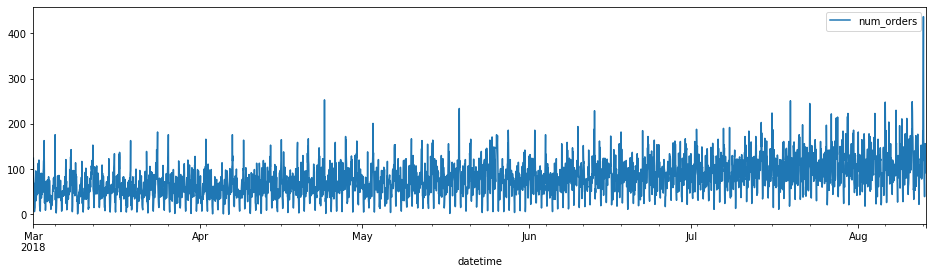

In [10]:
plt.figure(figsize=(16, 4))

data[:'2018-08-13 14:00:00'].plot(ax=plt.gca())

Número de órdenes por hora de Marzo a Agosto de 2018. Se puede apreciar una ligera tendencia al alza. La dispersión de los datos parece aumentar ligeramente conforme avanza el tiempo. Los datos parecen fluctuar de manera muy abrupta.

A continuación se muestra el histograma de número de órdenes para las fechas estipuladas.

<AxesSubplot:xlabel='num_orders', ylabel='Count'>

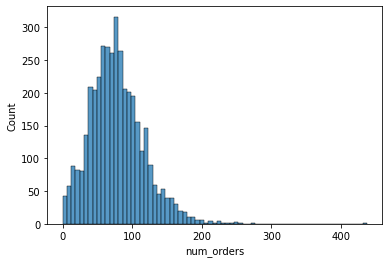

In [11]:
sns.histplot(data[:'2018-08-13 14:00:00']['num_orders'])

In [12]:
data[:'2018-08-13 14:00:00']['num_orders'].describe()

count    3975.000000
mean       78.296604
std        38.668774
min         0.000000
25%        52.000000
50%        75.000000
75%       101.000000
max       437.000000
Name: num_orders, dtype: float64

El promedio de órdenes por hora es de alrededor de 78, con una mediana de 75. El número máximo de órdenes en una hora fue de 437. Se aprecian muchos valores atípicos.

## Análisis Exploratorio

A continuación se calcula el número de órdenes por día y se obtienen sus componentes de tendencia, estacionaria y residual. De esta manera se pueden observar tendencias generales. 

In [13]:
daily_data = seasonal_decompose(data[:'2018-08-13 14:00:00'].resample('1D').sum())

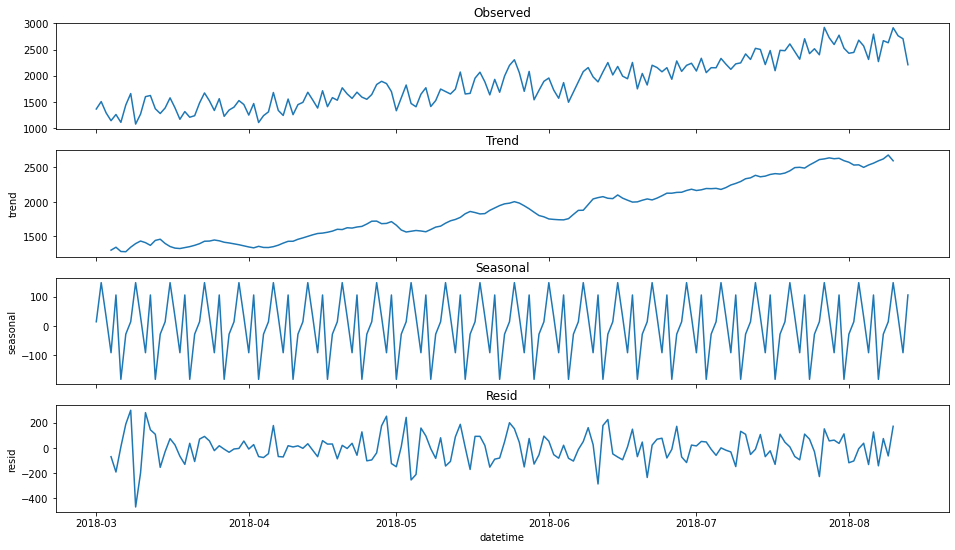

In [14]:
components =[daily_data.observed, daily_data.trend, daily_data.seasonal,  daily_data.resid]
titles = ['Observed', 'Trend', 'Seasonal', 'Resid']

fig, axs = plt.subplots(nrows=4, sharex=True, figsize=(16, 9))

for i, component in enumerate(components):
    sns.lineplot(data=component, ax=axs[i] )
    axs[i].set_title(titles[i])

Gráfico de Número de total de órdenes al día (arriba) y sus componentes de tendencia, estacional y residuo. Se observa una tendencia creciente en el número de órdenes. El periodo de la componente estacional parece ser una semana. Es importante remarcar que la amplitud de la componente residual es mayor a la componente estacional.

Para ver mayor detalle en las tendencias a continuación se muestra el gráfico de número de órdenes por hora y sus componentes para el mes de junio,

In [15]:
hourly_data = seasonal_decompose(data['2018-06-01':'2018-06-30'])

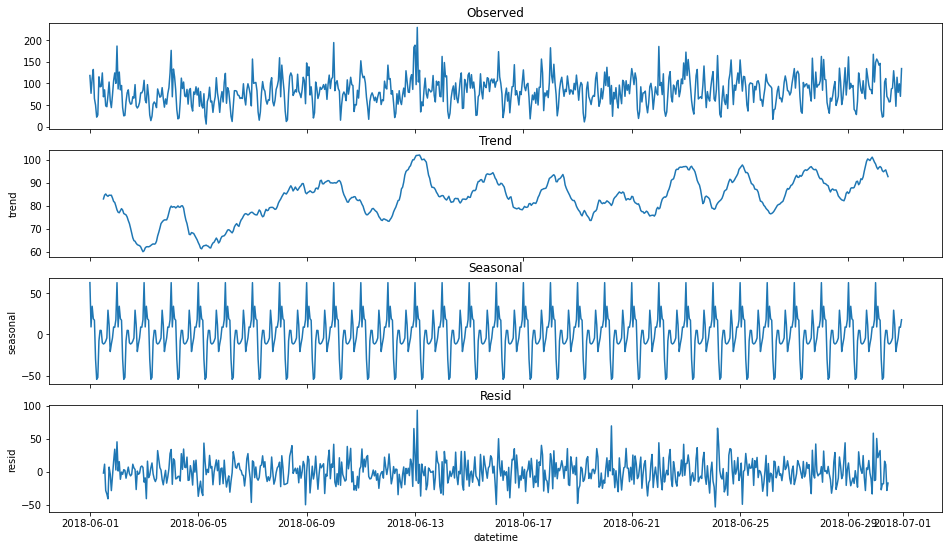

In [16]:
components =[hourly_data.observed, hourly_data.trend, hourly_data.seasonal,  hourly_data.resid]
titles = ['Observed', 'Trend', 'Seasonal', 'Resid']

fig, axs = plt.subplots(nrows=4, sharex=True, figsize=(16, 9))

for i, component in enumerate(components):
    sns.lineplot(data=component, ax=axs[i] )
    axs[i].set_title(titles[i])

Gráfico de Número de total de órdenes por hora (arriba) y sus componentes de tendencia, estacional y residuo. La componente de tendencia también es creciente, pero parece también tener oscilaciones. Por otro lado la componente estacional tiene una clara periodicidad de un día. 

A continuación se muestran las componentes de tendencia y estacional para el periodo del 11 de junio al 18 de junio.

<AxesSubplot:xlabel='datetime'>

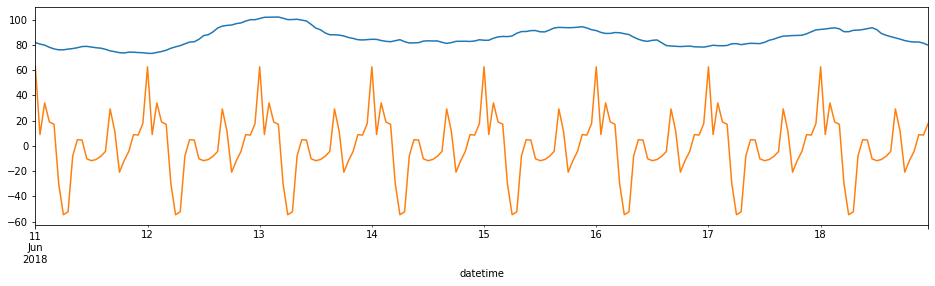

In [17]:
plt.figure(figsize=(16, 4))

hourly_data.trend['2018-06-11':'2018-06-18'].plot(ax=plt.gca())
hourly_data.seasonal['2018-06-11':'2018-06-18'].plot(ax=plt.gca())

Componentes de tendencia y estacional para el número de órdenes por hora del día, en el periodo del 11 de Junio al 18 de Junio del 2018. En esta gráfica se pueden apreciar los cambios periódicos que dependen de la hora. Para apreciarlo con más detalle se muestra la gráfica de la componente estacional para un día.

<AxesSubplot:xlabel='datetime'>

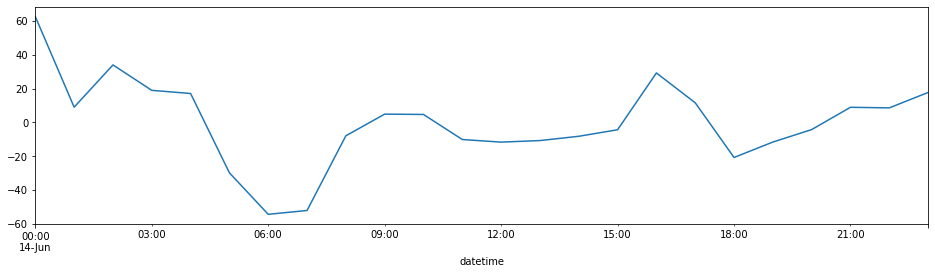

In [18]:
plt.figure(figsize=(16, 4))
hourly_data.seasonal['2018-06-14'].plot(ax=plt.gca())

Gráfica de la componenete estacional de número de órdenes por hora. Se pueden apreciar máximoa a las 12am, 2am, y 4pm y un mínimo a las 6am. 

## Preparación de características

En base a las observaciones de la sección anterior, se extraen características que pueden ser reelevantes, como número de mes, número de día, día de la semana, hora y número de día por año.

In [19]:
data['month'] = data.index.month
data['day'] = data.index.day
data['day_of_week'] = data.index.dayofweek
data['hour'] = data.index.hour


data['day_of_year'] = data.index.dayofyear

Estas características se repiten de forma cíclica a medida que avanzan en el tiempo, sin embargo lo hacen de forma abrupta. Por lo cual se hace una codificación de tal manera que cada característica se mapea a un círculo unitario por medio de las funciones seno y coseno.

Esto también ayuda con el escalado, pues las nuevas características van de -1 a 1.

In [20]:
def encode(data, cols):
    """
    Codifica las características periódicas en componentes seno y coseno.
    Parámetros:
    - data: DataFrame.
    - cols: Lista con nombres de columnas a codificar.
    Devuelve:
    - DataFrame con columnas codificadas
    """
    for col in cols:
        max_val = data[col].max()
        data[col + '_sin'] = np.sin(2 * np.pi * data[col] / max_val)
        data[col + '_cos'] = np.cos(2 * np.pi * data[col] / max_val)
        
    return data

Se definen las características periódicas y se aplica la función anterior. Se descartan las características no codificadas.

In [21]:
periodic_features = ['month', 
                     'day', 
                     'day_of_week', 
                     'hour']

data = encode(data, periodic_features)

data = data.drop(columns=periodic_features)

También se añaden características de desfase de 1 a 5 horas, y un desfase de 24 horas.

Se añaden el promedio y la desviación estándar para las 24 horas anteriores, de manera que se incluye la información suavizada que se exploró en la sección anterior. 

Por último se añade la diferencia de órdenes entre las dos últimas horas anteriores.

In [22]:
for lag in range(1, 6):
        data['minus_{}h'.format(lag)] = data['num_orders'].shift(lag)

data['minus_1d'] = data['num_orders'].shift(24)
    
data['rolling_day_mean'] = data['num_orders'].shift().rolling(24).mean()
data['rolling_day_std'] = data['num_orders'].shift().rolling(24).std()
    
data['diff'] =  data['minus_1h'] - data['minus_2h']

Adicionalmente añadimos dos columnas con la media y desviación estándar móviles ponderadas exponencialmente. Estas dos funciones son similares a sus contrapartes 'rolling' pero el resultado se calcula ponderando los valores de acuerdo a qué tan recientes son. 

In [23]:
data['emw_mean'] = data['num_orders'].shift().ewm(span=2).mean()

data['emw_std'] = data['num_orders'].shift().ewm(span=2).std()

Se calcula la matriz de correlación y se muestra el mapa de calor. Los coeficientes de correlación se calculan excluyendo el conjunto de prueba

In [24]:
corr_matrix = data[:'2018-08-13 14:00:00'].corr()

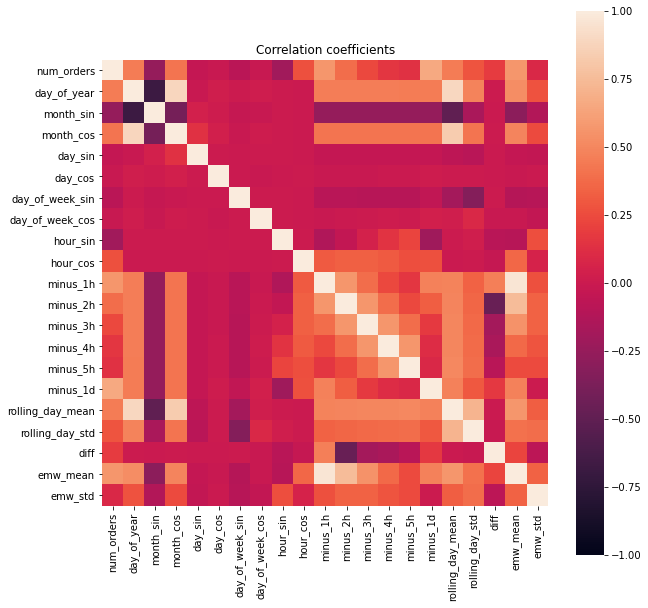

In [25]:
fig, ax_corr = plt.subplots(figsize=(10,10))
ax_corr = sns.heatmap(corr_matrix, vmin=-1, vmax=1, square=True)
ax_corr.set_title('Correlation coefficients')
plt.show()

Mapa de calor de nivel de correlación entre características. Se busca encontrar las características con mayor nivel de correlación con el objetivo, en este diagrama se pueden visualizar como los cuadros de la primera columna que tienen colores más contrastantes, cercanos al naranja claro y al negro.

Las características con mayor correlación con el número de ordenes son las características de desfase de 1 hora, 1 día y el promedio rodante ponderado exponencialmente, por lo que se espera que los modelos les den mayor significancia. Otras características que pueden afectar los modelos son el promedio rodante, el día del año, la componente coseno del mes y el desfase de 2 horas. 

Las características con menor correlación con el objetivo parecen ser día del mes y día de la semana.

Por otro lado se observa una anticorrelación con la componente seno de la hora. 

### Segmentación

Se segmenta el conjunto de datos con 10% para prueba. Del 90% restante, se utiliza una tercera parte para el conjunto de validación y dos terceras partes para el entrenamiento. De manera que al final queda 60% entrenamiento, 30% validación y 10% de prueba.

In [26]:
train, test = train_test_split(data, test_size=0.1, shuffle=False, random_state=12345)

In [27]:
train, valid = train_test_split(train, test_size=(1/3), shuffle=False, random_state=12345)

Se eliminan las filas con datos nulos del conjunto de entrenamiento.

In [28]:
train = train.dropna()

Se separan las características y el objetivo de cada conjunto.

In [29]:
y_train = train['num_orders']
X_train = train.drop(columns='num_orders')

y_valid = valid['num_orders']
X_valid = valid.drop(columns='num_orders')

y_test = test['num_orders']
X_test = test.drop(columns='num_orders')

### Evaluación

Se crea una función para evaluar los modelos. Calcula la RECM y el coeficiente de determinación R2.

In [30]:
def evaluate(target, prediction):
    rmse =  np.sqrt(mean_squared_error(target, prediction))
    r2 = r2_score(target, prediction)
    return [rmse, r2]

## Prueba de cordura

Se evalúan la RECM y el score R2 para un modelo que siempre devuelve el número de órdenes de la hora anterior. 

In [31]:
pred_previous = X_valid['minus_1h']

evaluate(y_valid, pred_previous)

[42.43177876375917, -0.1450426802920184]

El coeficiente de determinación R2 es negativo, lo cual indica que este modelo tiene menor precisión que un modelo que siempre devuelva el promedio de los valores objetivo.

## Formación

Se evalúan tres modelos: Regresión lineal, Árbol de Decisión y Descenso de gradiente. El primer modelo puede servir para detectar la tendencia general de la serie de tiempo. Los otros dos pueden ayudar a identificar la importancia que cada modelo asigna a cada característica. La función objetivo a minimizar es la RECM.

In [32]:
lr = LinearRegression()
tree = DecisionTreeRegressor(random_state=12345)
gbm = lgb.LGBMRegressor(boosting_type="gbdt", objective="regression", num_rounds=150, random_state=12345)

Se establecen las métricas a evaluar y se crea un dataframe para guardar los resultados.

In [33]:
models = { 'Linear Regression': lr, 'Tree': tree, 'Gradient Boost': gbm}
metrics = ['RMSE', 'R2_score']

results_valid = pd.DataFrame(index=models, columns=metrics)

Se crea una función para entrenar, predecir y evaluar los modelos.

In [34]:
def fit_pred_eval(model, model_key, X_train, y_train, X_valid, y_valid, results):
    
    model.fit(X_train, y_train) #entrena
    predicted = model.predict(X_valid) #predice
    
    results.loc[model_key]= evaluate(y_valid, predicted) #evalua y guarda
    
    display(results.loc[model_key])
    #guarda la predicción
    prediction= pd.Series(predicted, index=y_valid.index, name='pred'+model_key)

    #muestra una gráfica comparativa   
    fig, ax1 = plt.subplots(figsize=(16, 4))
    
    sns.lineplot(data=prediction, ax=ax1)
    
    sns.lineplot(data=y_valid, alpha=0.6, ax=ax1)
    
    plt.legend(('predicted','observed'))

    return plt.show


Iniciamos con el modelo de regresión lineal.

RMSE        31.1528
R2_score    0.38279
Name: Linear Regression, dtype: object

<function matplotlib.pyplot.show(close=None, block=None)>

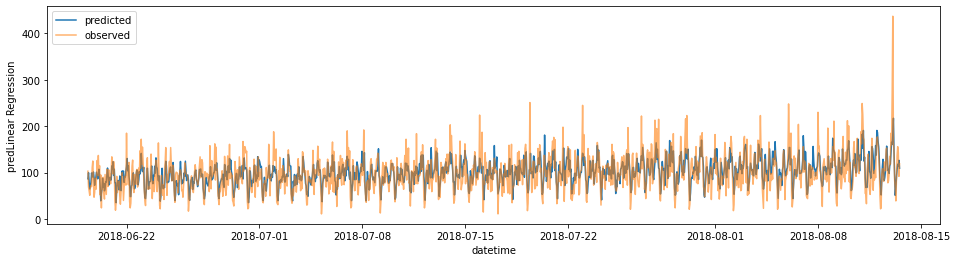

In [35]:
fit_pred_eval(lr, 'Linear Regression', X_train, y_train, X_valid, y_valid, results_valid)

El modelo tiene mejores métricas que la prueba de cordura. El modelo hizo un excelente trabajo detectando las oscilaciones debidas a la hora del día, pero falla al deectar valores más extremos.

## Ajuste de hiperparámetros

El siguiente modelo que se analiza es un Árbol de Decisión. Se utiliza el método GridSearchCV de la librería sklearn para encontrar los parámetros que minimicen la RECM. En este caso se itera sobre valores de máxima profundidad y n

In [36]:
tree_grid = {'max_depth': range(1, 20),
             'min_samples_leaf' : range(2,3,4),
             #'splitter': ['best', 'random'],
             #'min_weight_fraction_leaf' :[0.01, 0.1]
                         }

In [37]:
search_tree = GridSearchCV(tree, tree_grid, scoring='neg_root_mean_squared_error', refit=True)
search_tree.fit(X_train, y_train)
print('Best parameters: ', search_tree.best_params_, 'Best RMSE :', -search_tree.best_score_ )

Best parameters:  {'max_depth': 4, 'min_samples_leaf': 2} Best RMSE : 24.079858356111796


Una vez encontrados los parámetros ajustados se muestra el resultado para el conjunto de validación.

RMSE         43.7188
R2_score   -0.215558
Name: Tree, dtype: object

<function matplotlib.pyplot.show(close=None, block=None)>

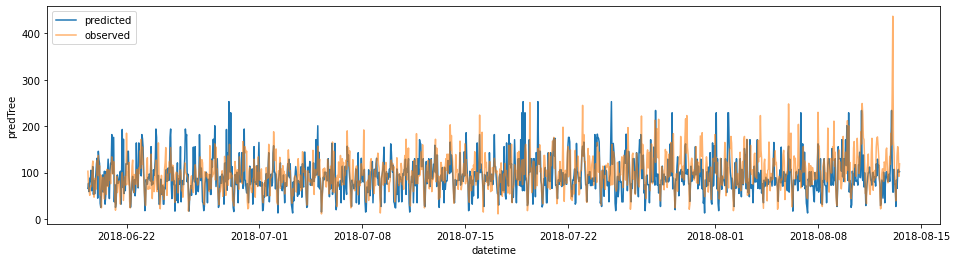

In [38]:
fit_pred_eval(tree, 'Tree', X_train, y_train, X_valid, y_valid, results_valid)

Este modelo tiene peores resultados que el anterior. En cuanto a la predicción se puede notar que los valores máximos y mínimos tienen aproximadamente la misma amplitid, sin embargo no captura las oscilaciones de la misma manera que el modelo anterior.

Adicionalmente se guardan los coeficientes de importancia que el modelo asignó a cada característica.

In [39]:
tree_weights = pd.Series(tree.feature_importances_ , index=X_train.columns, name='tree' )

Finalmente se hace una búsqueda de hiperparámetros para el modelo de Descenso de Gradiente. Se itera entre número de hojas y learning rate.

In [40]:
#Se crea un dataset para lgb
lgb_train = lgb.Dataset(X_train , y_train)

#parámetros para la búsqueda
params = {
    "num_leaves": range(8,19),
    "learning_rate": [0.01, 0.05, 0.1],
    "feature_fraction": [1],
    "bagging_fraction": [0.20]
}

reg_gb = GridSearchCV(gbm, params , scoring='neg_root_mean_squared_error', refit=True)
reg_gb.fit(X_train, y_train)
print('Best parameters: ', reg_gb.best_params_, 'Best RMSE :', -reg_gb.best_score_ )

/opt/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/opt/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/opt/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/opt/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/opt/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning: Foun

/opt/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/opt/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/opt/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/opt/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/opt/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning: Foun

/opt/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/opt/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/opt/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/opt/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/opt/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning: Foun

/opt/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/opt/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/opt/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/opt/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/opt/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning: Foun

/opt/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/opt/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/opt/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/opt/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/opt/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning: Foun

Best parameters:  {'bagging_fraction': 0.2, 'feature_fraction': 1, 'learning_rate': 0.05, 'num_leaves': 16} Best RMSE : 20.600230816165084


Se muestran los resultados para el modelo ajustado. 

RMSE        31.2943
R2_score    0.37717
Name: Gradient Boost, dtype: object

<function matplotlib.pyplot.show(close=None, block=None)>

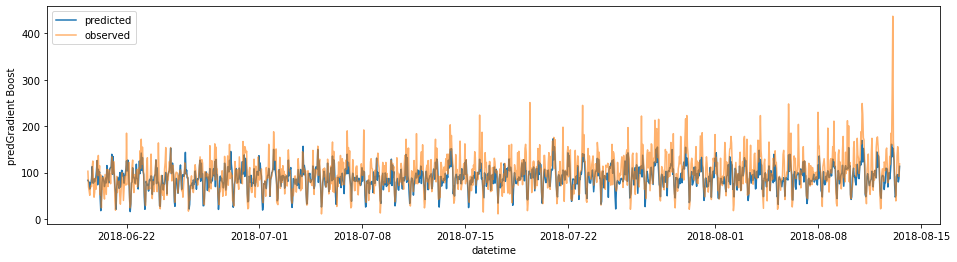

In [41]:
fit_pred_eval(gbm, 'Gradient Boost', X_train, y_train, X_valid, y_valid, results_valid)

El modelo tiene mejores resultados que los anteriores, al igual que el modelo de regresión lineal, logra captar la naturaleza cíclica de los datos, sin embargo falla al estimar apropiadamente el rango para los valores más extremos.

También se guardan las importancias de cada característica.

In [42]:
gb_weights = pd.Series( gbm.feature_importances_ , index=X_train.columns, name='gb' )

A continuación se muestran los resultados para el conjunto de validación. 

In [43]:
results_valid

,RMSE,R2_score
Linear Regression,31.1528,0.38279
Tree,43.7188,-0.215558
Gradient Boost,31.2943,0.37717


Los modelos de regresión lineal y descenso de gradiente superan las métricas de la prueba de cordura y tienen métricas muy similares. 

Por último se muestran los pesos que los modelos de árbol y gradiente asignaron a cada característica.

In [44]:
weights= pd.concat([tree_weights, gb_weights], join='outer', axis=1)

In [45]:
weights

,tree,gb
day_of_year,0.030166,280
month_sin,0.002525,0
month_cos,0.005744,9
day_sin,0.027606,167
day_cos,0.008349,124
day_of_week_sin,0.005669,91
day_of_week_cos,0.023633,101
hour_sin,0.312531,297
hour_cos,0.065324,202
minus_1h,0.032382,212


Se puede observar que ambos modelos dan importancia a distintas características. El descenso de gradiene da mayor ponderación a las características de desfase y promedios rodantes. El árbol de decisión da prioridad al número de órdenes de la hora anterior y a la componente senoidal de la hora del día.

## Prueba

Por último se muestran los resultados para todos los modelos en el conjunto de prueba.

In [46]:
pred_previous = X_test['minus_1h']

evaluate(y_test, pred_previous)

[58.856486242815066, -0.010510099401707107]

In [47]:
results_test = pd.DataFrame(index=models, columns=metrics)

In [48]:
for key, value in models.items():
    predicted_test = value.predict(X_test)    
    results_test.loc[key]= evaluate(y_test, predicted_test)

In [49]:
summary = results_test.merge(results_valid, how='outer', on=results_test.index, suffixes=('_test', '_valid'))

In [50]:
summary

,key_0,RMSE_test,R2_score_test,RMSE_valid,R2_score_valid
0,Linear Regression,46.5044,0.36913,31.1528,0.38279
1,Tree,68.0704,-0.351663,43.7188,-0.215558
2,Gradient Boost,55.9002,0.0884534,31.2943,0.37717


Los tres modelos disminuyeron su calidad en el conjunto de prueba, lo cual indica un sobreajuste. El modelo con las peores métricas es el Árbol de decisión, con peores métricas que la prueba de cordura. 

El descenso de gradiente supera los resultados de la prueba de cordura pero tiene un gran sobreajuste. 

Finalmente, el modelo de regresión lineal tiene las mejores métricas y los resultados más consistentes.

## Conclusiones 

El objetivo del presente proyecto es encontrar un modelo para predecir el número de órdenes de taxis en el aeropuero para la siguiente hora, tomando como referencia valores históricos.

Se empieza por analizar las tendencias generales de los datos, para lo cual se calculan el número de órdenes por hora y por día. Para estas dos muestras se obtienen sus componetes de tendencia, estacionalidad y residuo y se grafican. 

Para el número de total de órdenes al día, se observa una tendencia creciente en el número de órdenes. El periodo de la componente estacional parece ser una semana. La amplitud de la componente residual es mayor a la componente estacional.

Para el número de total de órdenes por hora, la componente de tendencia también es creciente, pero parece también tener oscilaciones. Por otro lado la componente estacional tiene una clara periodicidad de un día. 

En base al análisis exploratorio se añaden las siguientes características: 

- Número de mes, de 1 a 24
- Día del mes, de 1 a 31
- Día de la semana, de 0 a 6
- Hora, de 0 a 23
- Número del día del año

Para las primeras características se hace una codificación periódica, que consiste en hacer un mapeo a dos  componentes: seno y coseno. Esto ayuda a suavizar el valor de las características a través del tiempo y a su vez ayuda a escalar los datos.

Por otro lado, se añaden características de desfase:
- Número de órdenes de la n hora anterior, con n de 1 a 5. 
- Promedio móvil de las 24 horas anteriores.
- Desviación estándar móvil de las 24 horas anteriores.
- Diferencia de número de órdenes entre las dos horas anteriores

Adicionalmente se añadieron dos columnas con la media y desviación estándar móviles ponderadas exponencialmente. Estas dos funciones son similares a sus contrapartes 'rolling' pero el resultado se calcula ponderando los valores de acuerdo a qué tan recientes son. 

- Promedio móvil  ponderado exponencialmente.
- Desviación estándar móvil ponderado exponencialmente.

Se realiza un mapa de calor de nivel de correlación entre características para entender cuáles de las características tienen mayor nivel de correlación con el objetivo.

Las características con mayor correlación con el número de ordenes son las características de desfase de 1 hora, 1 día y el promedio rodante ponderado exponencialmente. Entre las características con correlación moderada se encuentran el promedio rodante, el día del año, la componente coseno del mes y el desfase de 2 horas.

Las características con menor correlación con el objetivo parecen ser día del mes y día de la semana.

Por otro lado se observa una anticorrelación con la componente seno de la hora.

Posteriormente se realiza una segmentación de los datos en conjunto de entrenamiento (60%), validación (30%) y prueba(10%).

Se realiza una prueba de cordura con un modelo dummy que devuelve el valor objetivo de la hora anterior. Este modelo tiene menor precisión que un modelo constante. 

Se evalúan tres modelos: regresión lineal, árbol de decisión y descenso de gradiente. Para los dos últimos modelos se hace un ajuste de hiperparámetros con GridSearch. Posteriormente se calculan las métricas RECM y score R2 para el conjunto de validación. 

Adicionalmente se grafican las series de tiempo predichas y se comparan con la serie de tiempo observada. Se muestran los resultados para el conjunto de validación:

In [51]:
results_valid

,RMSE,R2_score
Linear Regression,31.1528,0.38279
Tree,43.7188,-0.215558
Gradient Boost,31.2943,0.37717


Los modelos de regresión lineal y descenso de gradiente logran captar la naturaleza cíclica de los datos, sin embargo falla al estimar apropiadamente el rango para los valores más extremos. 

Una vez establecidos los modelos finales se procede a evaluar con el conjunto de prueba y se obtienen los siguientes resultados:

In [52]:
results_test

,RMSE,R2_score
Linear Regression,46.5044,0.36913
Tree,68.0704,-0.351663
Gradient Boost,55.9002,0.0884534


Los tres modelos disminuyeron su calidad en el conjunto de prueba, lo cual indica un sobreajuste. El modelo con las peores métricas es el Árbol de decisión, con peores métricas que la prueba de cordura. 

El descenso de gradiente supera los resultados de la prueba de cordura pero tiene un gran sobreajuste. 

Finalmente, el modelo de regresión lineal tiene las mejores métricas y los resultados más consistentes.